In [101]:
import pandas as pd
import quandl, math, datetime
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pickle

plt.style.use('fivethirtyeight')

## EDA

### Getting data from Quandl

In [28]:
df = quandl.get('WIKI/GOOGL')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3424 entries, 2004-08-19 to 2018-03-27
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         3424 non-null   float64
 1   High         3424 non-null   float64
 2   Low          3424 non-null   float64
 3   Close        3424 non-null   float64
 4   Volume       3424 non-null   float64
 5   Ex-Dividend  3424 non-null   float64
 6   Split Ratio  3424 non-null   float64
 7   Adj. Open    3424 non-null   float64
 8   Adj. High    3424 non-null   float64
 9   Adj. Low     3424 non-null   float64
 10  Adj. Close   3424 non-null   float64
 11  Adj. Volume  3424 non-null   float64
dtypes: float64(12)
memory usage: 347.8 KB
None


,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [29]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0


In [30]:
# % change in High and Low
df['HL_PCT'] = ((df['Adj. High'] - df['Adj. Low']) / df['Adj. Low']) * 100
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100
df.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,HL_PCT,PCT_change
Date,,,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0,8.441017,0.324968
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0,8.537313,7.227007
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0,4.062357,-1.227880
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0,7.753210,-5.726357
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0,3.966115,1.183658


### Features are finalized

In [31]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume', ]]

df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,8.441017,0.324968,44659000.0
2004-08-20,54.322689,8.537313,7.227007,22834300.0
2004-08-23,54.869377,4.062357,-1.227880,18256100.0
2004-08-24,52.597363,7.753210,-5.726357,15247300.0
2004-08-25,53.164113,3.966115,1.183658,9188600.0


In [38]:
forecast_col = 'Adj. Close'

# Make the null calues outliers
df.fillna(-99999, inplace=True)

# 10% of the dataset
forecast_out = int(math.ceil(0.01*len(df)))
forecast_out

35

In [45]:
# Create a new label: shifting the data by -1 % percent of dataframe length
df['label'] = df[forecast_col].shift(-forecast_out)
df.dropna(inplace=True)
df.tail()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2017-12-07,1044.57,1.309689,0.820408,1437448.0,1177.37
2017-12-08,1049.38,1.009695,-0.231030,1479665.0,1182.22
2017-12-11,1051.97,1.137800,0.081818,1096997.0,1181.59
2017-12-12,1048.77,1.687291,-0.117143,1684977.0,1119.20
2017-12-13,1051.39,0.850389,-0.065584,1369580.0,1068.76


### Goal: We are trying to forecast the stock price using the 'Adjusted Closing' price

What have we done till now?
- Filter out the necessary columns
- Shift the 'Adj. Close' price column by 1% of length of data set
- Put that shifted price as a new column 'label'
- So now we have current closing price and forecast closing price.
- We can use this to train the model to make predictions

## Training and testing using Linear Regression

### Using scikit learn

In [81]:
# Preparing the x and y data
x = np.array(df.drop(['label'], 1))
y = np.array(df['label'])

x = preprocessing.scale(x)

# Split data set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

classifier = LinearRegression()
# To use SVM
# classifier = svm.SVR() # Not so accurate here

classifier.fit(x_train, y_train)
accuracy = classifier.score(x_test, y_test)

# Uses Squared error as performance metric
accuracy

<ipython-input-81-b11d31289e80>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x = np.array(df.drop(['label'], 1))


0.9771464514265713

### Make predictions

Text(0, 0.5, 'Price')

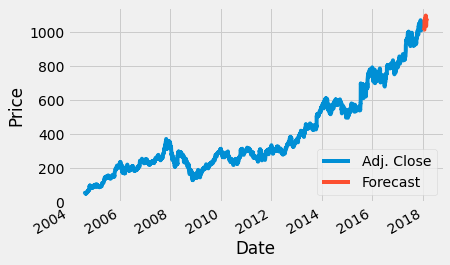

In [100]:
# Take some data points
x_lately = x[-forecast_out:]

forecast_set = classifier.predict(x_lately)

# Populate forecast 
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]

df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc = 4)
plt.xlabel('Date')
plt.ylabel('Price')